# CNN-Based Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we investigate a new **self-supervised deep learning approach** for peak fitting in synthetic XRD-CT datasets, and compare it to a conventional parameter-based fitting workflow. Both approaches are applied to a phantom dataset generated using the `nDTomo` package, simulating realistic peak shapes and background contributions under Poisson noise.

Peak fitting remains a critical step in XRD-CT analysis, enabling the extraction of quantitative parameters such as phase content, strain, and crystallite size. However, traditional voxel-by-voxel fitting methods can be slow, sensitive to noise, and difficult to scale. Here, we test whether a CNN trained directly on downsampled spectra can learn to infer accurate and denoised peak parameter maps.

## 🎯 Objectives

By the end of this notebook, you will:
- Generate a synthetic 3D XRD-CT dataset with spatially varying Gaussian peaks and linear background
- Add realistic Poisson noise to simulate photon-limited experiments
- Fit the data using two approaches:
  - Conventional parameter map-based fitting
  - **PeakFitCNN**: a self-supervised CNN that infers peak parameters from downsampled input
- Evaluate and compare the accuracy and noise robustness of both methods

## 🤖 What is PeakFitCNN?

PeakFitCNN is a **self-supervised convolutional neural network** designed to learn peak parameters from hyperspectral XRD-CT data **without needing ground truth labels**. It works by:
- Receiving a 4× downsampled hyperspectral input volume
- Predicting full-resolution parameter maps (amplitude, position, width, background slope and intercept)
- Reconstructing the spectra using a differentiable peak model
- Optimizing only through the reconstruction error

This approach naturally combines **denoising**, **super-resolution**, and **peak decomposition**, while avoiding the instability of pixel-wise nonlinear curve fitting.

## 📦 Dataset

We will use a synthetic dataset constructed as follows:
- Each voxel contains a **single Gaussian peak** with a linear background
- The five peak parameters vary smoothly across the field of view
- The diffraction axis is sampled over:

$$
(x, y, q) = (240, 240, 50)
$$

where $q$ represents the diffraction domain (e.g., $2\theta$).

Poisson noise is added to approximate photon-counting uncertainty, mimicking experimental conditions.

We now begin by importing the required modules and generating the simulated dataset.

## 🏗️ Generate Synthetic Spatial Maps

We begin by generating five synthetic 2D spatial images using the `nDTomophantom_2D()` function. Each image (`im1` to `im5`) will later be used to define a different peak or background parameter (e.g., peak position, width, amplitude, background slope/intercept) across the field of view.

These phantoms serve as parameter maps with smoothly varying features, simulating different chemical or structural domains in a realistic XRD-CT sample.

We also normalize `im5` so that it scales between 0 and 1, which is useful for defining background offset values. Finally, the spatial maps are visualized using `showim()` to verify the underlying structures.

c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\xdesign\geometry\area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


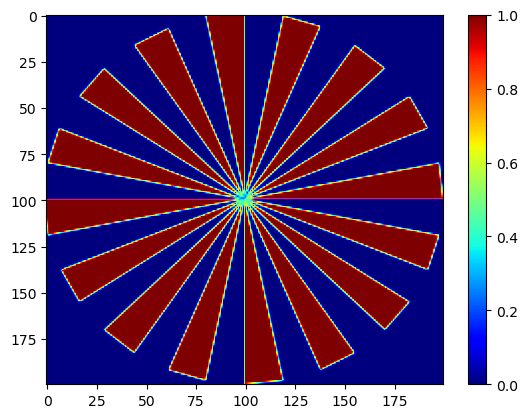

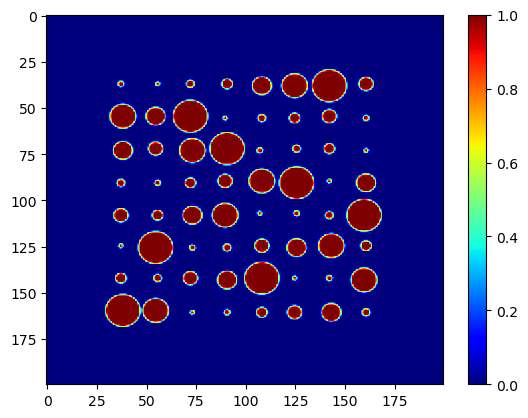

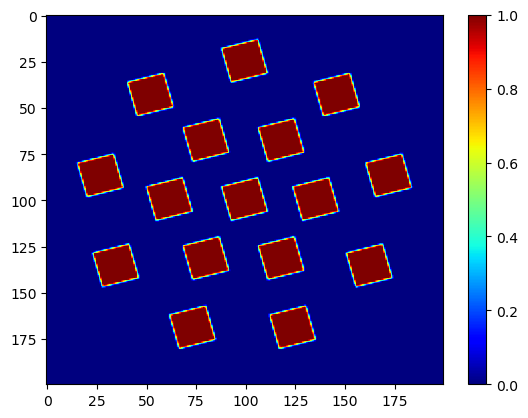

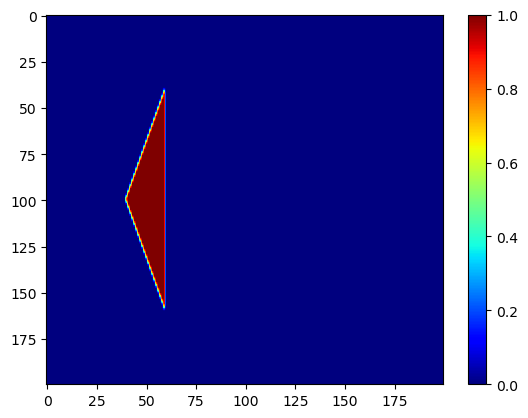

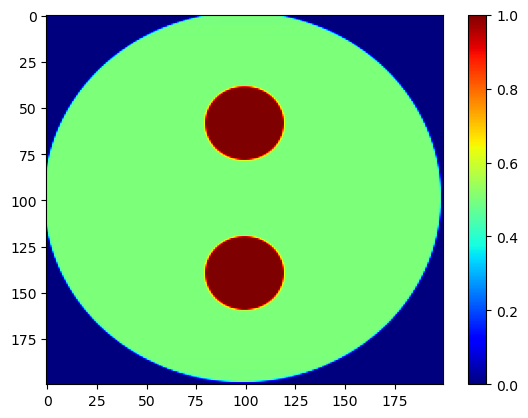

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim


# Create 2D spatial images for the five components
npix = 200
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


## 🧪 Simulate Hyperspectral Volume with Spatially Varying Peak Parameters

We now define the **analytical peak model** used to generate our synthetic dataset. Each voxel in the volume will contain a spectrum consisting of a **single Gaussian peak** with a **linear background**.

Two functions are defined:
- `gaussian(x, A, mu, sigma)` – generates a peak given amplitude, center, and width
- `linear_background(x, slope, intercept)` – models a linear baseline across the diffraction axis

We then:
1. Define the diffraction axis `x`, sampled between 0 and 5 with a step size of 0.1
2. Specify the valid parameter ranges for all five quantities:
   - **Peak amplitude** (A): varies with `im2 + im5`
   - **Peak position** (μ): varies with `im2`
   - **Peak width** (σ): varies with `im3`
   - **Background slope**: varies with `im4`
   - **Background intercept**: varies with `im5`

The resulting 2D hyperspectral image `vol` is populated voxel-by-voxel, only in regions with non-negligible peak amplitude (`mask_tmp > 0`).

We then pad the hyperspectral image spatially by 20 pixels on each side to ensure compatibility with CNN architectures that may expect padding or stride-sensitive dimensions.

Finally, we simulate **Poisson noise** using the `addpnoise3D()` function, which mimics photon-counting statistics typically observed in synchrotron X-ray imaging. The noise level is controlled by a `ct` value (e.g. 100 = moderate photon count). The resulting noisy synthetic dataset will be used for both conventional and CNN-based fitting.

In [8]:

def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.1)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


def addpnoise3D(vol, ct):
    '''
    Adds Poisson noise to a 3D hyperspectral volume (H x W x Bands),
    noise is added per pixel-spectrum (i.e., per (i,j,:)).
    
    Parameters
    ----------
    vol : ndarray
        3D hyperspectral image (H x W x Bands), must be non-negative.
    ct : float
        Scaling constant to simulate photon counts.
    '''
    vol = vol.copy()
    mi = np.min(vol)
    if mi < 0:
        vol = vol - mi + np.finfo(np.float32).eps
    elif mi == 0:
        vol = vol + np.finfo(np.float32).eps

    # Apply Poisson noise per pixel-spectrum
    noisy = np.random.poisson(vol * ct) / ct
    return noisy

# vol = vol + 0.001*np.random.rand(vol.shape[0], vol.shape[1], vol.shape[2])
# # vol = addpnoise3D(vol, ct=1000)
vol = addpnoise3D(vol, ct=100)
vol[vol<0] = 0



100%|██████████| 200/200 [00:00<00:00, 545.33it/s]


(240, 240, 50) 1.5


We can now interactively explore the spectral content of this volume using the chemimexplorer

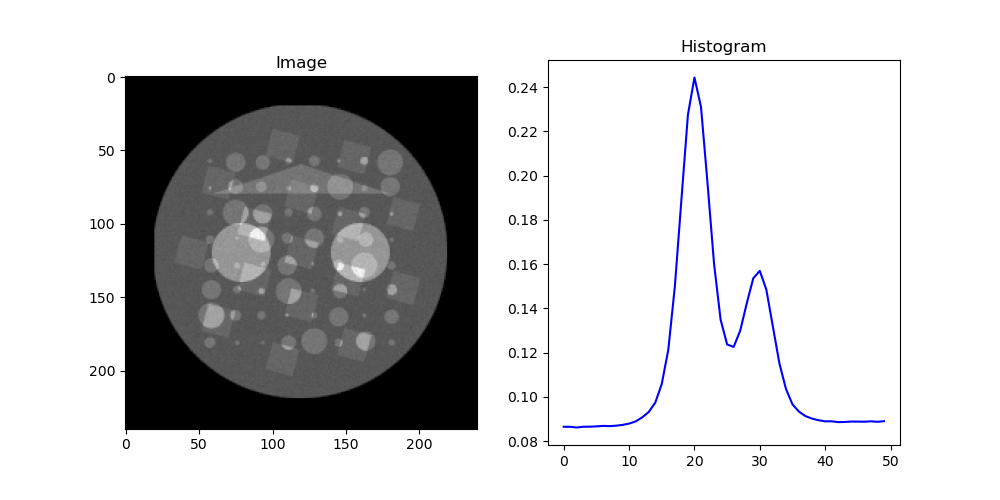

In [9]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(vol)

## 🎯 Patch Sampling Strategy for CNN Training

To train the PeakFitCNN model efficiently, we operate on smaller image patches rather than the full hyperspectral volume. This section defines a **patch-based sampling strategy** that allows randomized, GPU-efficient access to valid (non-zero) regions of the volume.

Key steps include:

1. **Patch and sampling parameters**:
   - `patch_size = 32`: the spatial size of each square patch
   - `num_patches = 16`: number of patches drawn per iteration (i.e., batch size)
   - `num_iterations = 100`: total training steps per epoch

2. **Valid mask generation**:
   - A binary mask is computed from the sum over spectral channels to identify meaningful (non-zero) regions.
   - Padding is added to the volume and mask to ensure valid patch extraction near image borders.

3. **Sampling diagnostics**:
   - We estimate the **percentage of pixels probed per epoch**, based on patch size and number.
   - We compute the **number of iterations required** to probe the entire image once.

4. **Patch index selection**:
   - Valid patch indices are extracted using `filter_patch_indices()` to avoid sampling background-only regions.
   - These indices are used to initialize a patch-based coverage `counter` which tracks how often each pixel is sampled.

5. **Visualization**:
   - We visualize both the binary mask and the patch coverage map, helping verify that the sampling scheme is balanced and covers all important regions.

This patch sampling setup enables training with limited memory while ensuring statistical coverage of the whole sample over multiple iterations.

(304, 304, 50) (240, 240, 50) (304, 304)


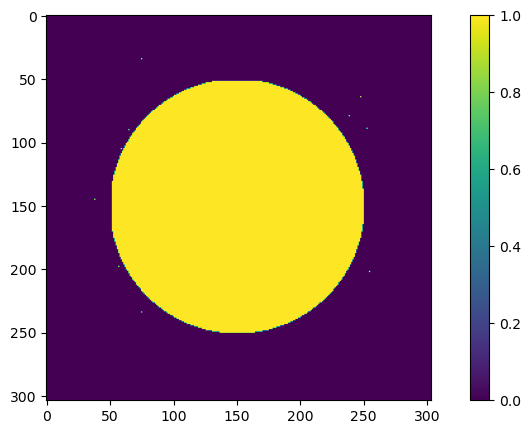

Percentage of pixels probed during one epoch: 51.65521155180024
Number of iterations required to probe full image: 2
The number of patches is  44
The number of iterations (batches) required to probe the whole image is  2
tensor(1.)


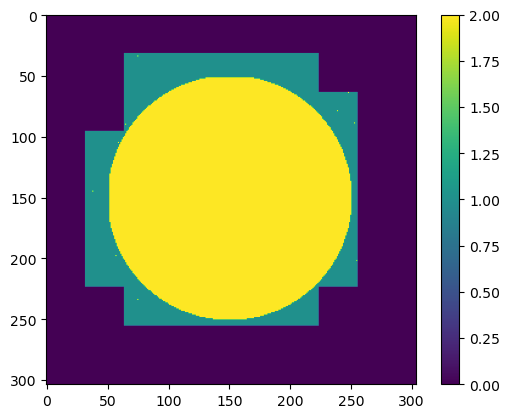

In [10]:
import torch, time
import torch.nn.functional as F
from torch import nn
from nDTomo.torch.utils_torch import calc_patches_indices, denormalize, filter_patch_indices, update_counter, initialize_counter, calc_patches_indices

%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(vol.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(vol,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(vol)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, vol.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

indices = filter_patch_indices(torch.tensor(mask), patch_size)
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )

counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)
print(counter.max())
counter = counter.numpy()

plt.figure(2);plt.clf()
plt.imshow(counter + mask)
plt.colorbar()
plt.show()

## 🧠 Define PeakFitCNN Architecture and Initial Parameter Model

This section defines the neural network components used in the PeakFitCNN pipeline.

### 📐 `PeakFitCNN` Class

The `PeakFitCNN` class implements a **self-supervised upsampling CNN** that takes a spatially downsampled hyperspectral input (e.g., 4× smaller) and predicts full-resolution maps of peak parameters. It supports configurable normalization (instance, batch, or layer norm), bilinear upsampling, and optional final activation (e.g., ReLU or Sigmoid).

- The input is typically the downscaled hyperspectral imaging data or a low-resolution estimate or feature map.
- The output is a stack of parameter maps (e.g., amplitude, center, width, background).
- The network upsamples via two stages (2× + 2× for a total 4×).

### 🧩 `PrmCNN2D` Class

The `PrmCNN2D` class provides a modular structure for representing the initial parameter maps:
- If `prms_layer=True`, it holds a set of **trainable parameter tensors**, e.g. initialized to zeros or random values.
- If `cnn_layer=True`, a CNN is applied to either:
  - the initialized parameters, or
  - a provided input volume.

This module can operate in **three modes**:
1. Parameter map only (`prms_layer=True`, `cnn_layer=False`) — conventional approach.
2. CNN only (`prms_layer=False`, `cnn_layer=True`) — fully learned from input.
3. Combined (`prms_layer=True`, `cnn_layer=True`) — trainable initial maps refined via CNN layers.

---

### 🔢 Configuration and Parameter Count

We define:
- A single Gaussian peak per spectrum (`num_peaks = 1`)
- 3 peak parameters (area, position, width)
- 2 background parameters (slope, intercept)
- `total_params = 5`

We instantiate the `PrmCNN2D` model in **parameter-map-only mode**, initialized to zero. This setup corresponds to the **conventional voxel-wise fitting approach**, where each parameter is independently stored as a learnable 2D map.

The total number of trainable parameters is printed for comparison with the full resolution grid size.

In [11]:

class PeakFitCNN(nn.Module):
    
    def __init__(self, nch_in=1, nch_out=1, nfilts=32, upscale_factor = 4,
                 norm_type='instance', activation='Linear', padding='same', npix=None):
        super(PeakFitCNN, self).__init__()

        self.npix = npix
        self.upscale_factor = upscale_factor
        # Initial feature extraction
        self.input = nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding, bias=True)

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
        layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
        # Add normalization based on norm_type
        if norm_type == "instance":
            layers.append(nn.InstanceNorm2d(nfilts, affine=True))
        elif norm_type == "batch":
            layers.append(nn.BatchNorm2d(nfilts))
        elif norm_type == "layer":
            layers.append(nn.LayerNorm([nfilts, 2*self.npix, 2*self.npix]))

        # Add activation function
        layers.append(nn.ReLU(inplace=True))

        self.upsample1 = nn.Sequential(*layers)

        if self.upscale_factor == 4:
            layers = []
            layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
            layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
            # Add normalization based on norm_type
            if norm_type == "instance":
                layers.append(nn.InstanceNorm2d(nfilts, affine=True))
            elif norm_type == "batch":
                layers.append(nn.BatchNorm2d(nfilts))
            elif norm_type == "layer":
                layers.append(nn.LayerNorm([nfilts, 4*self.npix, 4*self.npix]))
            # Add activation function
            layers.append(nn.ReLU(inplace=True))

            self.upsample2 = nn.Sequential(*layers)

        # Final output layer
        self.xrdct = nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding, bias=True)

        # Final activation
        self.final_activation = None
        if activation == "ReLU":
            self.final_activation = nn.ReLU()
        elif activation == "Sigmoid":
            self.final_activation = nn.Sigmoid()
        elif activation == "LeakyReLU":
            self.final_activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):  # Feature maps from autoencoder2D are passed

        x = self.input(x)

        # Upsampling 1
        x = self.upsample1(x)

        if self.upscale_factor == 4:
            # Upsampling 2
            x = self.upsample2(x)

        # Output layer
        x = self.xrdct(x)

        if self.final_activation is not None:
            x = self.final_activation(x)

        return x
    
class PrmCNN2D(nn.Module):
    def __init__(self, npix, nch_in=1, nch_out=1, nfilts=32, nlayers=4, norm_type='layer', 
                 prms_layer=True, cnn_layer=True, tensor_vals = 'random', tensor_initial = None,
                 padding='same'):
        super(PrmCNN2D, self).__init__()
        self.npix = npix
        self.prms_layer = prms_layer
        self.cnn_layer = cnn_layer

        if self.prms_layer:
            if tensor_vals == 'random':
                self.initial_tensor = nn.Parameter(2*torch.randn(1, nch_in, npix, npix)-1)
            elif tensor_vals == 'zeros':
                self.initial_tensor = nn.Parameter(torch.zeros(1, nch_in, npix, npix))
            elif tensor_vals == 'ones':
                self.initial_tensor = nn.Parameter(torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'mean':
                self.initial_tensor = nn.Parameter(0.5*torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'random_positive':
                self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
            elif tensor_vals == 'custom':
                try:
                    self.initial_tensor = nn.Parameter(tensor_initial)
                except:
                    print('Custom tensor not provided. Using random tensor instead')
                    self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
        if self.cnn_layer:
            layers = []
            layers.append(nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding))  # 'same' padding in PyTorch is usually done by manually specifying the padding
            if norm_type=='layer':
                if padding=='valid':
                    layers.append(nn.LayerNorm([nfilts, self.npix -2, self.npix -2]))
                else:
                    layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
            elif norm_type=='instance':
                layers.append(nn.InstanceNorm2d(nfilts, affine = True))
            elif norm_type=='batchnorm':            
                layers.append(nn.BatchNorm2d(nfilts))

            layers.append(nn.ReLU())

            for layer in range(nlayers):
                
                layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding))
                if norm_type=='layer':
                    if padding=='valid':
                        layers.append(nn.LayerNorm([nfilts, self.npix -2*(layer + 2), self.npix -2*(layer + 2)]))
                    else:
                        layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
                elif norm_type=='instance':
                    layers.append(nn.InstanceNorm2d(nfilts, affine = True))            
                elif norm_type=='batchnorm':            
                    layers.append(nn.BatchNorm2d(nfilts))

                layers.append(nn.ReLU())

            layers.append(nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding))
            layers.append(nn.Sigmoid())
            self.cnn2d = nn.Sequential(*layers)

    def forward(self, x):
        if self.prms_layer and self.cnn_layer:
            out = self.cnn2d(torch.sigmoid(self.initial_tensor))
        elif self.cnn_layer and not self.prms_layer:
            out = self.cnn2d(x)
        elif self.prms_layer and not self.cnn_layer:
            out = torch.sigmoid(self.initial_tensor)
        return out
    

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)


Total number of parameters: 462080
Conventional number of parameters: 462080


## 🧪 Train PeakFitCNN in a Self-Supervised Manner

We now train the `PeakFitCNN` model using a **self-supervised learning strategy** based on physical reconstruction of the spectra. The CNN is optimized to predict normalized peak parameter maps, from which we reconstruct the full hyperspectral volume and compare it directly to the observed data (`volp`).

### 🧱 Model Components

- **Gaussian model**: The `gaussian()` function defines the parametric form of the peak used for spectral reconstruction.
- **Normalization bounds**: We define `param_min` and `param_max` dictionaries that set the physical limits for each parameter type (Area, Position, FWHM, Slope, Intercept). These are used to scale network outputs to valid physical ranges.
- **Loss function**: Mean Absolute Error (L1 loss) is used as the reconstruction loss. Additional metrics (MSE, RMSE) are also tracked for monitoring.
- **Input image**: We create a single-channel static image from the sum of all spectral channels, normalized and reshaped appropriately for the CNN input.

### 🔁 Training Loop

The model is trained over multiple epochs using the following loop:
1. The CNN produces a set of normalized parameter maps (`yc`) from the static image input.
2. These maps are locally filtered and then **clamped** using a ±20% soft constraint (`prf`) to stabilize training.
3. Parameters are denormalized and used to reconstruct each spectrum voxel-by-voxel:
   - Gaussian peaks are added for each voxel using predicted amplitude, position, and width.
   - Linear background is then added using predicted slope and intercept.
4. The reconstructed spectra are compared to the ground truth data (`volp`) for randomly sampled patches.
5. Loss is computed using RMSE and gradients are backpropagated to update model parameters.

A learning rate scheduler reduces the step size upon plateauing, and early stopping is triggered if the minimum learning rate is reached.

### 🕒 Training Time & Convergence

This block tracks:
- Total training time
- Number of epochs until convergence
- Final MAE, MSE, RMSE
- A loss log (`logloss`) for plotting learning curves later

This setup enables **self-supervised training of peak parameters** without any labelled supervision — the only objective is to minimize the difference between the observed and reconstructed spectra.

In [12]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

with torch.no_grad():
    yprms = model(im_static)
    yprms = F.interpolate(yprms, scale_factor=1/4, mode='bilinear', align_corners=False)


epochs = 50000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)
        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)   
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

3


  0%|          | 4/50000 [00:00<22:39, 36.77it/s]

MAE =  tensor(0.5038, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3659, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6049, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6037533


  0%|          | 57/50000 [00:01<22:28, 37.04it/s]

MAE =  tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04095646


  0%|          | 106/50000 [00:02<22:54, 36.30it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037795603


  0%|          | 157/50000 [00:04<22:27, 37.00it/s]

MAE =  tensor(0.0268, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0374, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037111912


  0%|          | 205/50000 [00:05<22:09, 37.44it/s]

MAE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0371, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036858723


  1%|          | 257/50000 [00:06<22:49, 36.33it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036729723


  1%|          | 305/50000 [00:08<24:08, 34.30it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0369, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036647886


  1%|          | 358/50000 [00:09<22:29, 36.80it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0368, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036604863


  1%|          | 406/50000 [00:11<23:27, 35.24it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0368, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03657265


  1%|          | 454/50000 [00:12<24:17, 33.99it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0368, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036543034


  1%|          | 507/50000 [00:14<23:49, 34.62it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0368, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036515426


  1%|          | 556/50000 [00:15<23:30, 35.06it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0367, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036500715


  1%|          | 604/50000 [00:16<24:27, 33.66it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0367, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03649263


  1%|▏         | 657/50000 [00:18<22:04, 37.26it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0367, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03648597


  1%|▏         | 705/50000 [00:19<21:57, 37.40it/s]

MAE =  tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0367, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036472194


  2%|▏         | 757/50000 [00:21<22:01, 37.26it/s]

MAE =  tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0367, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036469772


  2%|▏         | 805/50000 [00:22<22:17, 36.79it/s]

Epoch 00798: reducing learning rate of group 0 to 5.0000e-02.
MAE =  tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036330655


  2%|▏         | 857/50000 [00:23<21:50, 37.49it/s]

MAE =  tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036260847


  2%|▏         | 908/50000 [00:25<21:53, 37.38it/s]

MAE =  tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036257967


  2%|▏         | 957/50000 [00:26<21:44, 37.60it/s]

MAE =  tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036255173


  2%|▏         | 1009/50000 [00:27<22:08, 36.87it/s]

MAE =  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036252607


  2%|▏         | 1058/50000 [00:29<21:42, 37.58it/s]

MAE =  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036250543


  2%|▏         | 1107/50000 [00:30<23:14, 35.06it/s]

MAE =  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036248367


  2%|▏         | 1156/50000 [00:31<23:30, 34.62it/s]

MAE =  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036246434


  2%|▏         | 1205/50000 [00:33<22:38, 35.92it/s]

MAE =  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036244415


  2%|▏         | 1249/50000 [00:34<22:03, 36.84it/s]

Epoch 01244: reducing learning rate of group 0 to 2.5000e-02.
MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036240738


  3%|▎         | 1306/50000 [00:35<21:38, 37.50it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036238655


  3%|▎         | 1355/50000 [00:37<22:01, 36.82it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036237676


  3%|▎         | 1405/50000 [00:38<22:21, 36.22it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036236815


  3%|▎         | 1436/50000 [00:39<21:13, 38.13it/s]

Epoch 01431: reducing learning rate of group 0 to 1.2500e-02.


  3%|▎         | 1457/50000 [00:39<21:45, 37.18it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036234744


  3%|▎         | 1507/50000 [00:41<21:31, 37.55it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036234193


  3%|▎         | 1556/50000 [00:42<23:02, 35.05it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036233667


  3%|▎         | 1584/50000 [00:43<21:32, 37.47it/s]

Epoch 01579: reducing learning rate of group 0 to 6.2500e-03.


  3%|▎         | 1604/50000 [00:43<22:22, 36.05it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623268


  3%|▎         | 1656/50000 [00:45<21:46, 37.01it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036232397


  3%|▎         | 1684/50000 [00:46<22:00, 36.59it/s]

Epoch 01680: reducing learning rate of group 0 to 3.1250e-03.


  3%|▎         | 1708/50000 [00:46<21:44, 37.01it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036231853


  4%|▎         | 1758/50000 [00:48<22:15, 36.13it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036231708


  4%|▎         | 1787/50000 [00:48<21:37, 37.16it/s]

Epoch 01781: reducing learning rate of group 0 to 1.5625e-03.


  4%|▎         | 1807/50000 [00:49<22:42, 35.37it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623142


  4%|▎         | 1856/50000 [00:50<21:54, 36.63it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036231324


  4%|▍         | 1889/50000 [00:51<21:17, 37.65it/s]

Epoch 01882: reducing learning rate of group 0 to 7.8125e-04.


  4%|▍         | 1905/50000 [00:52<23:01, 34.83it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036231175


  4%|▍         | 1957/50000 [00:53<22:24, 35.74it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623113


  4%|▍         | 1991/50000 [00:54<21:24, 37.38it/s]

Epoch 01983: reducing learning rate of group 0 to 3.9063e-04.


  4%|▍         | 2004/50000 [00:54<21:16, 37.59it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036231045


  4%|▍         | 2057/50000 [00:56<21:29, 37.17it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623102


  4%|▍         | 2090/50000 [00:57<22:09, 36.03it/s]

Epoch 02084: reducing learning rate of group 0 to 1.9531e-04.


  4%|▍         | 2106/50000 [00:57<22:53, 34.86it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036230966


  4%|▍         | 2155/50000 [00:59<22:30, 35.42it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036230955


  4%|▍         | 2191/50000 [01:00<23:05, 34.50it/s]

Epoch 02185: reducing learning rate of group 0 to 9.7656e-05.


  4%|▍         | 2208/50000 [01:00<22:02, 36.15it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036230933


  5%|▍         | 2256/50000 [01:02<22:16, 35.74it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623092


  5%|▍         | 2292/50000 [01:03<22:03, 36.05it/s]

Epoch 02286: reducing learning rate of group 0 to 4.8828e-05.


  5%|▍         | 2308/50000 [01:03<22:07, 35.92it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623091


  5%|▍         | 2358/50000 [01:04<21:26, 37.04it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036230903


  5%|▍         | 2391/50000 [01:05<21:04, 37.67it/s]

Epoch 02387: reducing learning rate of group 0 to 2.4414e-05.


  5%|▍         | 2409/50000 [01:06<21:05, 37.61it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0362309


  5%|▍         | 2456/50000 [01:07<20:59, 37.74it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0362309


  5%|▍         | 2492/50000 [01:08<21:18, 37.17it/s]

Epoch 02488: reducing learning rate of group 0 to 1.2207e-05.


  5%|▌         | 2505/50000 [01:08<20:48, 38.04it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036230892


  5%|▌         | 2554/50000 [01:10<20:53, 37.84it/s]

MAE =  tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03623089


  5%|▌         | 2588/50000 [01:11<21:41, 36.44it/s]

Epoch 02589: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
2588
2588 tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0365, device='cuda:0', grad_fn=<SqrtBackward0>) 0.03623089
71.03543186187744


## 📊 Visualize Training Loss and CNN-Predicted Parameter Maps

In this final section, we evaluate the performance of the trained PeakFitCNN model by visualizing both the training history and the reconstructed peak parameter maps.

### 📉 Loss Curve

We first plot the logged RMSE loss (`logloss`) across training epochs (starting from epoch 100 for clarity). This helps verify whether the model has converged and how stable the optimization process was.

### 🗺️ Extract Predicted Parameters from CNN

After training, we extract the output from the model:
- The raw predicted maps are optionally smoothed using a `3×3` average filter.
- Each parameter map (area, position, FWHM, slope, intercept) is **denormalized** to recover physical units.
- The output maps are spatially cropped to remove padding (based on the difference in shape between predicted and ground truth volumes).

### 🎯 Masked Comparison and Visual Output

To compare the CNN results with the ground truth:
- A mask is applied to focus only on the regions where meaningful signal exists (i.e., where `peak_area > 0.1`).
- The CNN-predicted maps are **concatenated side-by-side** with the corresponding ground truth maps for visual inspection.

This comparison is done for all five parameters:
1. **Peak Area**
2. **Peak Position**
3. **Peak FWHM**
4. **Background Slope**
5. **Background Intercept**

Each parameter is shown as a 2D image, where the **left half** corresponds to the ground truth and the **right half** shows the PeakFitCNN prediction (masked to remove background).

These visualizations help assess both spatial fidelity and denoising performance of the CNN-based peak fitting approach.

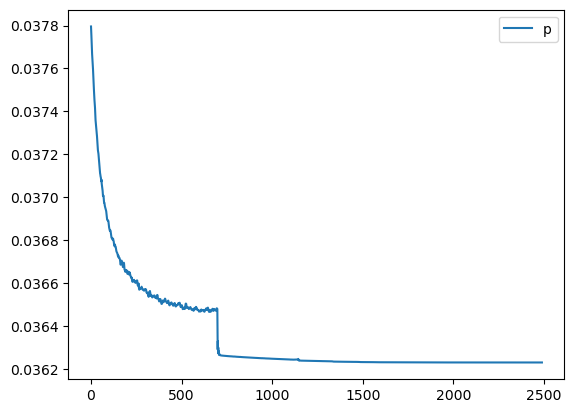

(304, 304) (304, 304) (304, 304) (304, 304) (304, 304)
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)
52
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)


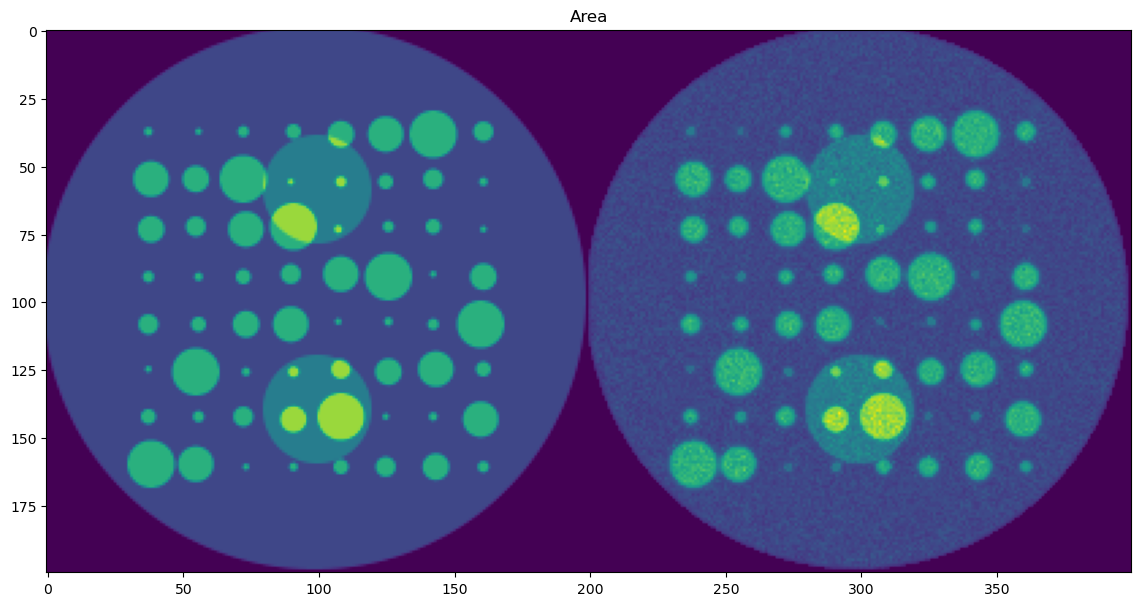

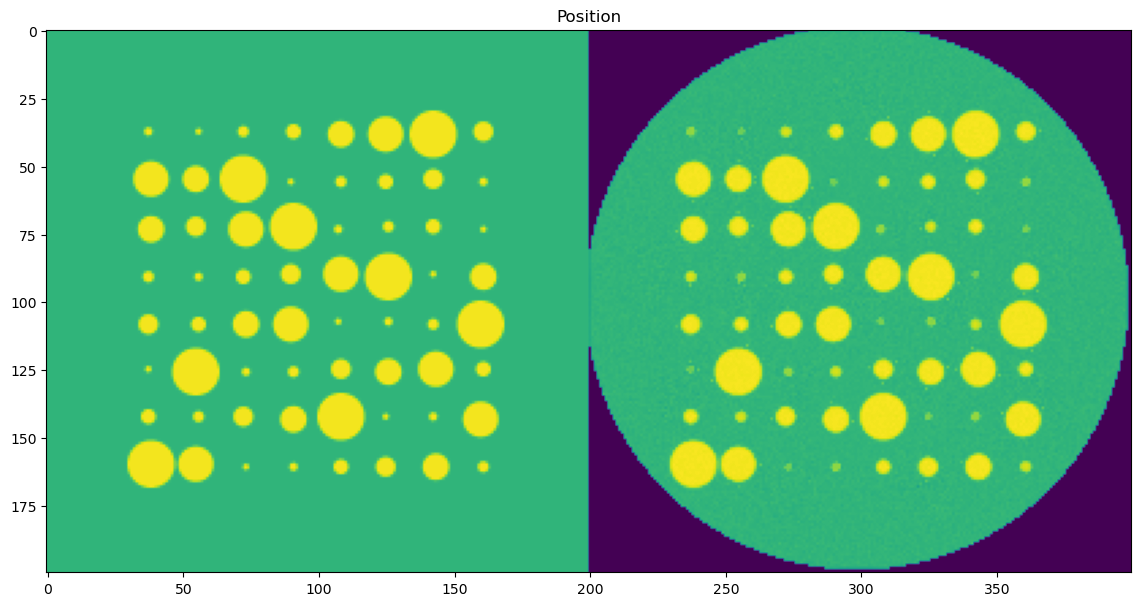

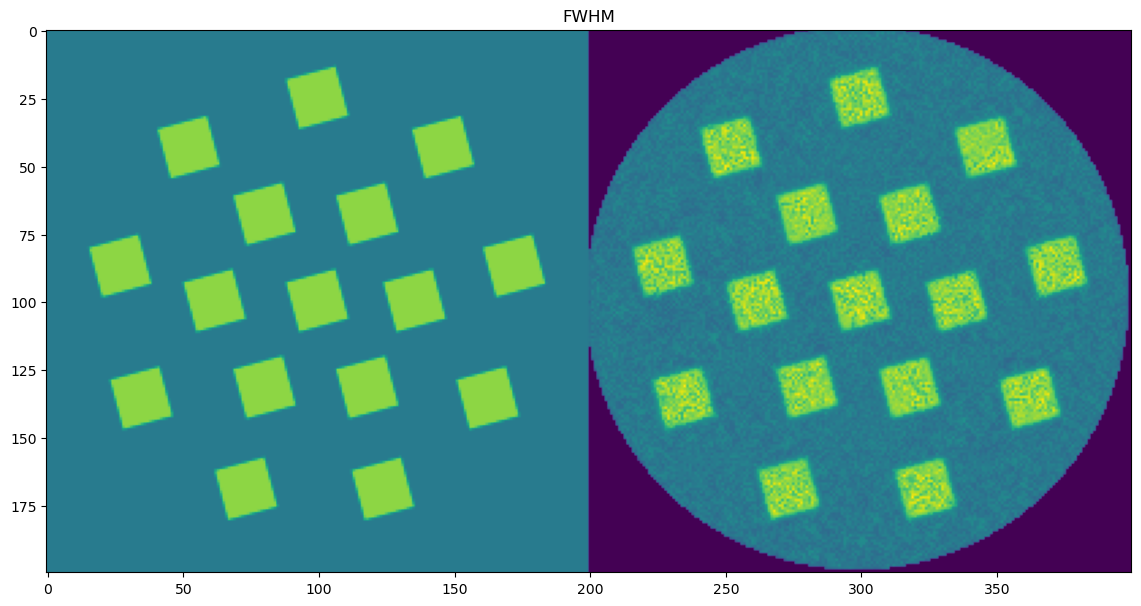

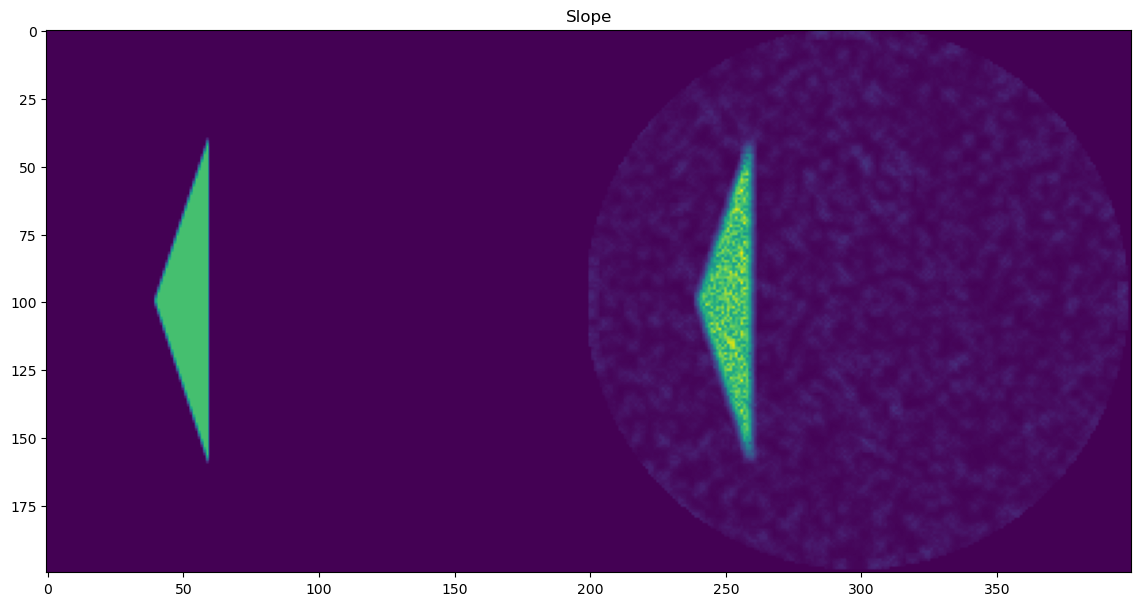

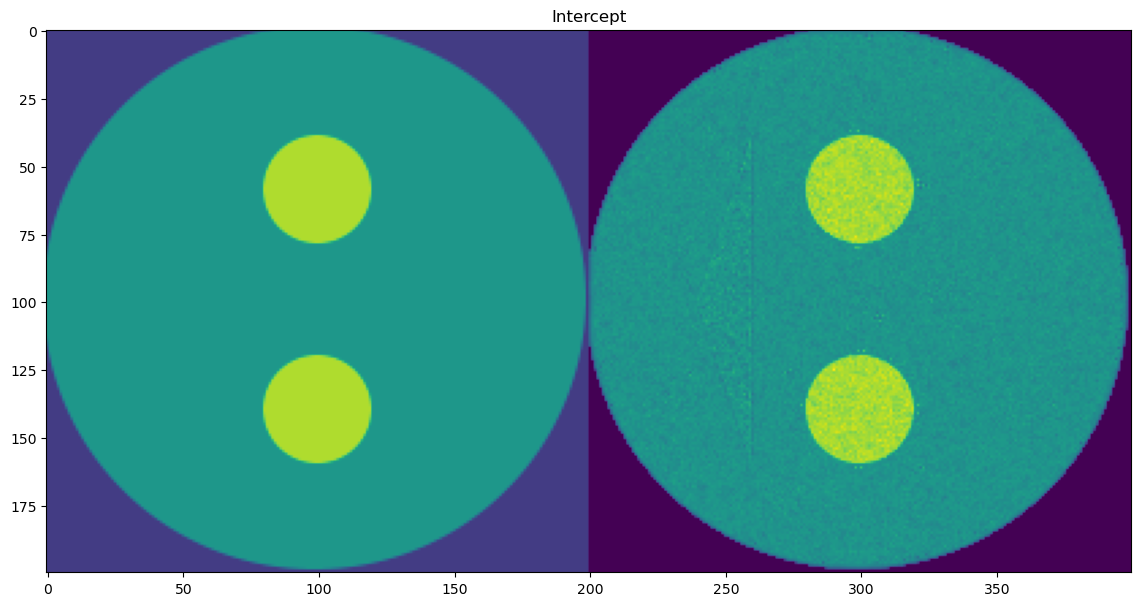

In [13]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('prms_only')
plt.show()

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()



## 🧠 Define and Prepare PeakFitCNN for Self-Supervised Training from Downsampled Input

We now instantiate the **PeakFitCNN model** that performs self-supervised peak fitting directly from **4× downsampled hyperspectral data**. This model is designed to replace the parameter map initialization used earlier with a CNN that learns the full-resolution parameter maps from a coarse input.

### 🏗️ Model Configuration

- `nch_in`: Number of input spectral channels (i.e., length of diffraction axis)
- `nch_out`: Number of predicted parameter maps (total of 5)
- `nfilts`: Number of filters in each layer; here set to match the number of input channels
- `upscale_factor`: 4× spatial upsampling to recover full-resolution output
- `norm_type`: Instance normalization for stability
- `activation`: Sigmoid activation ensures output values are bounded in [0, 1]

The total number of trainable parameters in the CNN is printed and compared against the number of parameters used in the **conventional approach**, which stores a separate value per parameter per voxel.

### 🔄 Prepare Inputs for CNN

We convert the original noisy 3D hyperspectral volume (`volp`) into a 4D tensor and **spatially downsample it** by a factor of 4 using bilinear interpolation. This downsampled input will be fed to the CNN to predict the full-resolution parameter maps.

This approach allows the model to:
- Exploit spatial context via convolution
- Combine denoising, peak fitting, and resolution enhancement in a single learned model

The shapes of both full-resolution and downsampled tensors are printed for verification.

In [14]:

model_cnn = PeakFitCNN(nch_in=volp.shape[2], nch_out=nch_out, nfilts=64,  upscale_factor = 4, norm_type='instance', 
              activation='Sigmoid', padding='same').to(device)
nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out, npix)

print("Conventional number of parameters:", npix*npix*total_params)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)
downsampled = F.interpolate(yobs, scale_factor=1/4, mode='bilinear', align_corners=False)

print(downsampled.shape, yobs.shape, yobs.shape[2]/4)

Total number of parameters: 105861
Number of filters: 50
5 304
Conventional number of parameters: 462080
torch.Size([1, 50, 76, 76]) torch.Size([1, 50, 304, 304]) 76.0


## 🔁 Train PeakFitCNN from Downsampled Hyperspectral Input

We now train the **PeakFitCNN model** using the 4× downsampled hyperspectral input volume. This deep-learning approach replaces explicit parameter map initialization with a CNN trained end-to-end to predict all peak parameters.

The training follows the same **self-supervised spectral reconstruction strategy** as before, but now the input is downsampled data and the model itself performs both super-resolution and peak fitting.

### ⚙️ Training Configuration

- `epochs = 50000`: maximum number of training epochs
- `prf = 0.2`: ±20% soft constraint around local average predictions to stabilize training
- `patience = 200`: used by the learning rate scheduler to detect plateaus
- `optimizer`: Adam with an initial learning rate of `0.001`
- `scheduler`: learning rate is halved on plateaus, down to a minimum of `1e-5`
- `num_patches`: number of spatial patches processed per batch

### 🧠 Training Loop

For each epoch:
1. A forward pass is performed using the downsampled hyperspectral data as input.
2. The CNN predicts full-resolution normalized parameter maps (`yc`).
3. A local average filter is applied, and values are **clamped within ±20%** of the smoothed estimates.
4. Spectral reconstruction is done using the same Gaussian + linear background model.
5. Random patches of the predicted and ground truth spectra are extracted.
6. The **RMSE loss** is computed between predicted and true spectra, and used for backpropagation.

The loop continues until convergence or the minimum learning rate is reached.

### 📈 Output

At the end of training, the code logs:
- Final **epoch count**
- Final **MAE, MSE, RMSE**
- Total **training time** in seconds
- A full log of the RMSE loss at each epoch (`logloss`), which can later be plotted to assess convergence

This completes the training of the second fitting approach, where **PeakFitCNN directly learns to denoise and fit peak parameters from low-resolution hyperspectral input**.

In [15]:

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

prf = 0.2
epochs = 50000
patience = 200
learning_rate = 0.001
min_lr = 1E-5
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model_cnn(downsampled)

        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
        lower_bound = filtered * (1.0 - prf)
        upper_bound = filtered * (1.0 + prf)
        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False) 
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

3


  0%|          | 4/50000 [00:01<5:08:02,  2.71it/s] 

MAE =  tensor(0.2866, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1700, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4123, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.48477864


  0%|          | 103/50000 [00:06<37:13, 22.34it/s] 

MAE =  tensor(0.0313, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0554, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.05485487


  0%|          | 205/50000 [00:11<38:35, 21.51it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0517, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.051529568


  1%|          | 304/50000 [00:16<40:04, 20.67it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0491, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04951805


  1%|          | 403/50000 [00:20<38:42, 21.36it/s]

MAE =  tensor(0.0280, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0476, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.047541164


  1%|          | 505/50000 [00:25<38:26, 21.46it/s]

MAE =  tensor(0.0273, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0458, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04479904


  1%|          | 604/50000 [00:30<38:45, 21.25it/s]

MAE =  tensor(0.0273, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0454, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04448781


  1%|▏         | 703/50000 [00:34<39:33, 20.77it/s]

MAE =  tensor(0.0265, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0433, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.043583095


  2%|▏         | 805/50000 [00:39<39:58, 20.51it/s]

MAE =  tensor(0.0265, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0431, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0424579


  2%|▏         | 904/50000 [00:44<39:04, 20.94it/s]

MAE =  tensor(0.0262, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0424, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.042408194


  2%|▏         | 1003/50000 [00:48<38:29, 21.21it/s]

MAE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0428, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.042202517


  2%|▏         | 1105/50000 [00:53<37:55, 21.49it/s]

MAE =  tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0416, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.041127834


  2%|▏         | 1204/50000 [00:58<38:23, 21.18it/s]

MAE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0421, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.041518696


  3%|▎         | 1303/50000 [01:03<38:14, 21.23it/s]

MAE =  tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0417, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.041258752


  3%|▎         | 1405/50000 [01:07<38:20, 21.12it/s]

MAE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0421, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04217952


  3%|▎         | 1504/50000 [01:12<37:21, 21.63it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04045349


  3%|▎         | 1603/50000 [01:17<37:40, 21.41it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040476933


  3%|▎         | 1705/50000 [01:21<38:03, 21.15it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040395234


  4%|▎         | 1804/50000 [01:26<38:34, 20.82it/s]

MAE =  tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040466726


  4%|▍         | 1903/50000 [01:31<39:04, 20.51it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04015269


  4%|▍         | 2005/50000 [01:36<38:33, 20.75it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03999387


  4%|▍         | 2104/50000 [01:41<38:54, 20.52it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040984474


  4%|▍         | 2203/50000 [01:45<36:57, 21.55it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039970394


  5%|▍         | 2305/50000 [01:50<36:55, 21.53it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0404, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040374056


  5%|▍         | 2359/50000 [01:52<37:33, 21.14it/s]

Epoch 02357: reducing learning rate of group 0 to 5.0000e-04.


  5%|▍         | 2404/50000 [01:55<37:17, 21.27it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039187312


  5%|▌         | 2503/50000 [01:59<38:13, 20.71it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039122928


  5%|▌         | 2605/50000 [02:04<36:55, 21.39it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039043166


  5%|▌         | 2704/50000 [02:09<37:24, 21.07it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03913325


  6%|▌         | 2803/50000 [02:13<38:12, 20.59it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039032996


  6%|▌         | 2905/50000 [02:18<36:46, 21.35it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039105922


  6%|▌         | 3004/50000 [02:23<36:00, 21.75it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038868334


  6%|▌         | 3103/50000 [02:28<38:25, 20.35it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03894759


  6%|▋         | 3202/50000 [02:32<37:22, 20.87it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039043233


  7%|▋         | 3304/50000 [02:37<35:58, 21.63it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038731065


  7%|▋         | 3403/50000 [02:42<35:49, 21.68it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038948577


  7%|▋         | 3505/50000 [02:47<36:27, 21.26it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03871083


  7%|▋         | 3604/50000 [02:51<37:02, 20.87it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0387, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03860084


  7%|▋         | 3703/50000 [02:56<36:49, 20.95it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038669452


  8%|▊         | 3805/50000 [03:01<37:00, 20.81it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038868923


  8%|▊         | 3832/50000 [03:02<36:14, 21.23it/s]

Epoch 03830: reducing learning rate of group 0 to 2.5000e-04.


  8%|▊         | 3904/50000 [03:06<36:04, 21.30it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03847932


  8%|▊         | 4003/50000 [03:10<36:33, 20.97it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038460173


  8%|▊         | 4105/50000 [03:15<36:02, 21.23it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038450316


  8%|▊         | 4204/50000 [03:20<37:18, 20.46it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038454235


  9%|▊         | 4303/50000 [03:25<35:52, 21.23it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038512565


  9%|▉         | 4381/50000 [03:28<35:54, 21.17it/s]

Epoch 04379: reducing learning rate of group 0 to 1.2500e-04.


  9%|▉         | 4405/50000 [03:29<35:57, 21.14it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03838712


  9%|▉         | 4504/50000 [03:34<35:07, 21.59it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038375657


  9%|▉         | 4603/50000 [03:39<35:42, 21.19it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03836886


  9%|▉         | 4705/50000 [03:43<35:21, 21.35it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038360186


 10%|▉         | 4804/50000 [03:48<36:08, 20.85it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038351156


 10%|▉         | 4903/50000 [03:53<35:41, 21.06it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038358457


 10%|█         | 5005/50000 [03:58<36:11, 20.72it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038325086


 10%|█         | 5104/50000 [04:02<35:27, 21.11it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038318824


 10%|█         | 5203/50000 [04:07<36:04, 20.69it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038323935


 11%|█         | 5305/50000 [04:12<35:16, 21.12it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038308226


 11%|█         | 5404/50000 [04:16<36:45, 20.22it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038301814


 11%|█         | 5503/50000 [04:21<35:15, 21.03it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03828489


 11%|█         | 5605/50000 [04:26<34:23, 21.51it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038274035


 11%|█▏        | 5704/50000 [04:31<34:08, 21.62it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03827761


 12%|█▏        | 5803/50000 [04:35<33:14, 22.16it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0382601


 12%|█▏        | 5905/50000 [04:40<34:55, 21.05it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038246356


 12%|█▏        | 6004/50000 [04:45<34:39, 21.16it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038262755


 12%|█▏        | 6103/50000 [04:50<35:15, 20.75it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038240783


 12%|█▏        | 6205/50000 [04:54<34:05, 21.41it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03823721


 13%|█▎        | 6304/50000 [04:59<35:18, 20.63it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03823369


 13%|█▎        | 6403/50000 [05:04<33:55, 21.42it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03822425


 13%|█▎        | 6505/50000 [05:08<33:44, 21.49it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03821815


 13%|█▎        | 6604/50000 [05:13<33:45, 21.42it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038204312


 13%|█▎        | 6705/50000 [05:18<36:10, 19.94it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038205482


 14%|█▎        | 6804/50000 [05:23<33:05, 21.76it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038206592


 14%|█▍        | 6903/50000 [05:27<33:46, 21.27it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038207572


 14%|█▍        | 7005/50000 [05:32<34:35, 20.72it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038188446


 14%|█▍        | 7104/50000 [05:37<33:47, 21.15it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038178723


 14%|█▍        | 7203/50000 [05:41<34:20, 20.77it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03820087


 15%|█▍        | 7305/50000 [05:46<33:35, 21.19it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038174942


 15%|█▍        | 7404/50000 [05:51<33:55, 20.93it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038169466


 15%|█▌        | 7503/50000 [05:56<32:51, 21.56it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038173035


 15%|█▌        | 7605/50000 [06:00<32:15, 21.90it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038156755


 15%|█▌        | 7704/50000 [06:05<33:13, 21.21it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03818108


 16%|█▌        | 7803/50000 [06:10<34:15, 20.53it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038158175


 16%|█▌        | 7905/50000 [06:15<33:13, 21.12it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038142003


 16%|█▌        | 8004/50000 [06:19<32:04, 21.82it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03815007


 16%|█▌        | 8103/50000 [06:24<32:07, 21.74it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038124926


 16%|█▋        | 8205/50000 [06:29<32:41, 21.31it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03815504


 16%|█▋        | 8247/50000 [06:31<32:23, 21.48it/s]

Epoch 08245: reducing learning rate of group 0 to 6.2500e-05.


 17%|█▋        | 8304/50000 [06:33<32:37, 21.30it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038098734


 17%|█▋        | 8403/50000 [06:38<33:41, 20.58it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03809565


 17%|█▋        | 8505/50000 [06:43<32:27, 21.31it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038094446


 17%|█▋        | 8604/50000 [06:47<32:18, 21.36it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038091205


 17%|█▋        | 8703/50000 [06:52<31:58, 21.53it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038093302


 17%|█▋        | 8745/50000 [06:54<31:35, 21.77it/s]

Epoch 08742: reducing learning rate of group 0 to 3.1250e-05.


 18%|█▊        | 8805/50000 [06:57<31:48, 21.59it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038082354


 18%|█▊        | 8904/50000 [07:01<32:38, 20.98it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038080167


 18%|█▊        | 9003/50000 [07:06<33:18, 20.51it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03807802


 18%|█▊        | 9105/50000 [07:11<32:39, 20.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038076192


 18%|█▊        | 9204/50000 [07:16<31:19, 21.70it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038074486


 19%|█▊        | 9303/50000 [07:20<31:27, 21.56it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03807226


 19%|█▉        | 9402/50000 [07:25<32:07, 21.07it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03806882


 19%|█▉        | 9504/50000 [07:30<32:51, 20.55it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038066544


 19%|█▉        | 9603/50000 [07:34<32:13, 20.89it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03806293


 19%|█▉        | 9702/50000 [07:39<32:29, 20.67it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03806136


 20%|█▉        | 9804/50000 [07:44<32:06, 20.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038058467


 20%|█▉        | 9903/50000 [07:49<32:13, 20.74it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038054608


 20%|██        | 10005/50000 [07:53<30:29, 21.86it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038053215


 20%|██        | 10104/50000 [07:58<31:43, 20.96it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038050197


 20%|██        | 10204/50000 [08:03<32:08, 20.63it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038048357


 21%|██        | 10303/50000 [08:08<31:08, 21.24it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038047444


 21%|██        | 10405/50000 [08:12<30:49, 21.41it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03804439


 21%|██        | 10504/50000 [08:17<30:34, 21.53it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038040966


 21%|██        | 10603/50000 [08:22<30:42, 21.38it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038037285


 21%|██▏       | 10705/50000 [08:27<31:10, 21.01it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03803657


 22%|██▏       | 10804/50000 [08:31<31:14, 20.91it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038033295


 22%|██▏       | 10891/50000 [08:35<29:45, 21.90it/s]

Epoch 10887: reducing learning rate of group 0 to 1.5625e-05.


 22%|██▏       | 10903/50000 [08:36<30:28, 21.39it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038028


 22%|██▏       | 11005/50000 [08:41<30:44, 21.14it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03802674


 22%|██▏       | 11104/50000 [08:45<30:55, 20.96it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03802549


 22%|██▏       | 11180/50000 [08:49<30:39, 21.11it/s]

Epoch 11181: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
11180
11180 tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>) 0.038024314
529.6869306564331


## 🧪 Compare Parameter Maps from PeakFitCNN and Conventional Approach

After training the PeakFitCNN model on downsampled input, we now extract and visualize the predicted parameter maps. This section mirrors the post-processing used earlier for the conventional parameter maps, allowing for direct visual comparison.

### 📉 Loss Curve

We first plot the RMSE loss curve from the PeakFitCNN training (`logloss`), starting from epoch 100. This helps assess whether the model has converged and how its behavior compares to the conventional approach.

### 🗺️ Extract CNN-Predicted Parameters

We:
- Perform a forward pass through the trained PeakFitCNN using the downsampled input
- Apply local smoothing (`3×3` average pooling)
- Clamp predictions within ±20% of the smoothed values
- Denormalize all five parameter maps: area, position, FWHM, slope, and intercept

As before, we crop the output to remove padding (`ofs`) and apply a binary mask (`msk`) to focus only on relevant signal regions.

### 🔍 Side-by-Side Comparison

For each parameter, we concatenate the following maps side-by-side:
1. **Ground truth** from the simulation
2. **Conventional parameter map** (fit via `PrmCNN2D`)
3. **CNN prediction** (from PeakFitCNN)

These are visualized with `imshow()` using the `'jet'` colormap to highlight spatial gradients.

This comparison allows us to qualitatively assess:
- Fidelity to the true parameter maps
- Degree of denoising
- Spatial continuity and sharpness

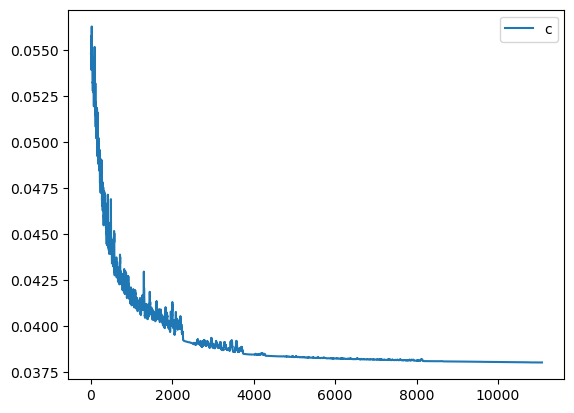

52
(200, 200) (200, 200) (200, 200)


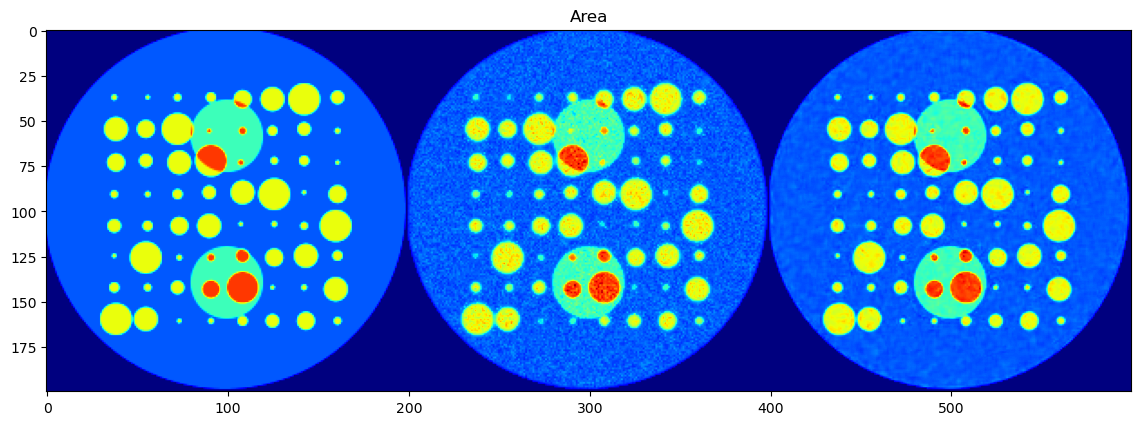

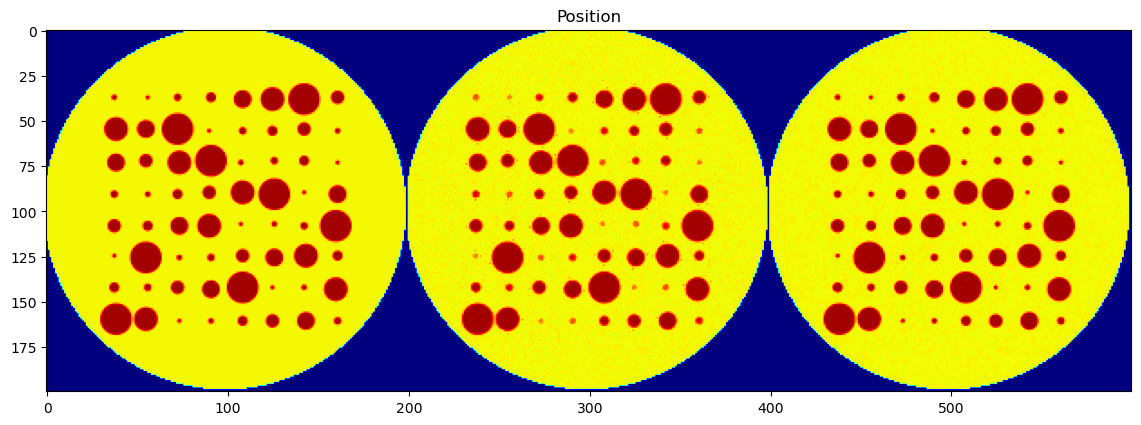

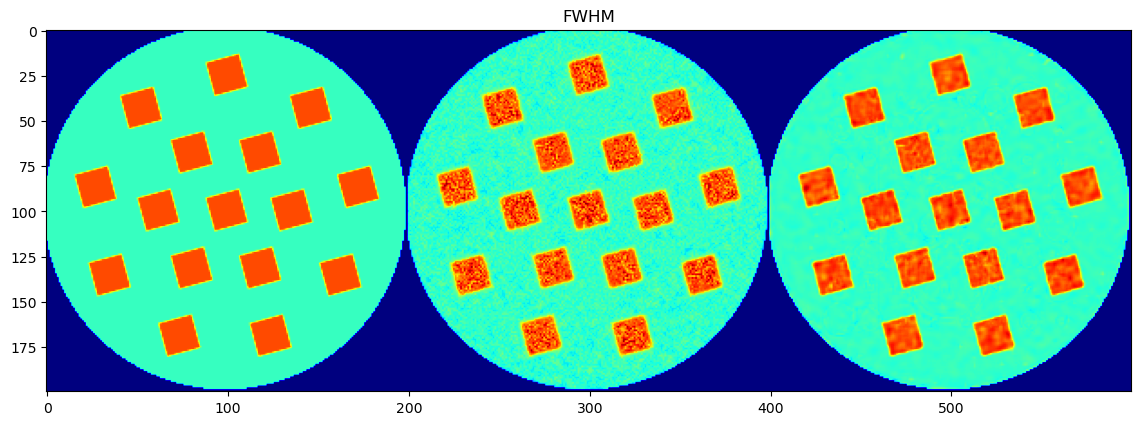

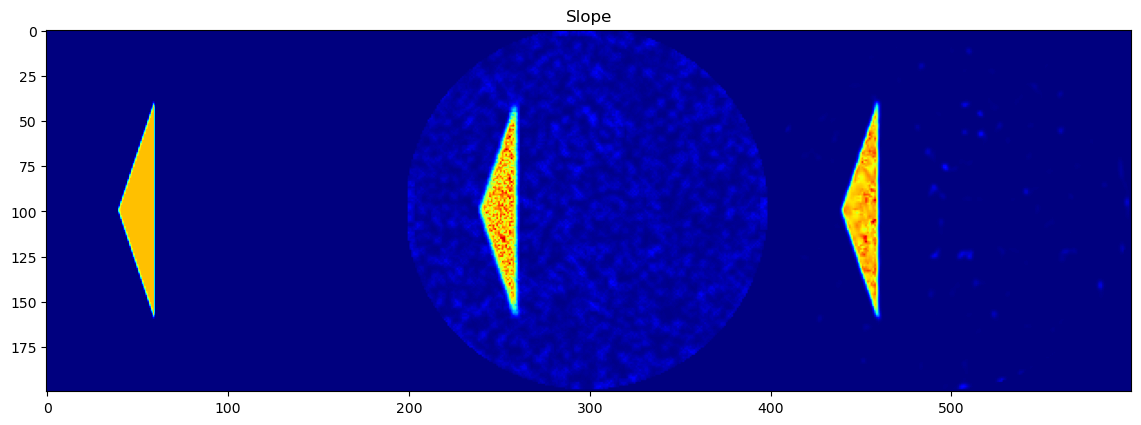

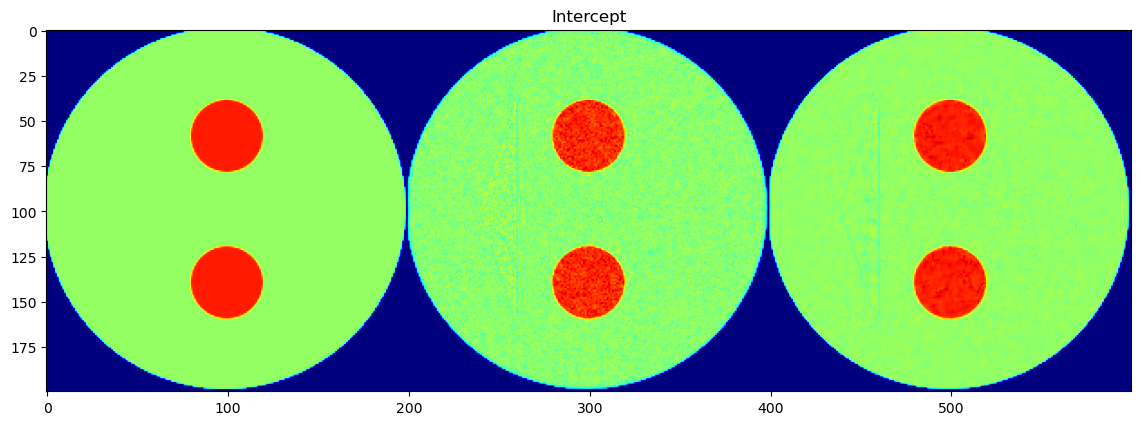

In [16]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

print(peak_area.shape, prms_peak1_area.shape, cnn_peak1_area.shape)

areac = np.concatenate((peak_area*msk, prms_peak1_area*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()


## ✅ Summary and Final Remarks

In this notebook, we compared two distinct strategies for hyperspectral peak fitting in synthetic XRD-CT datasets:

### 📌 Conventional Approach
- Uses explicit, per-parameter 2D maps to define each peak and background component.
- These parameter maps are trained directly to minimize spectral reconstruction error.
- While effective, this approach does not leverage spatial or spectral context beyond local filtering.

### 📌 PeakFitCNN (Self-Supervised CNN)
- Uses a downsampled hyperspectral input and learns to output **full-resolution, denoised parameter maps**.
- Trained using a **self-supervised loss** based on spectral reconstruction, requiring no labelled parameter maps.
- Combines denoising, resolution enhancement, and peak decomposition in a single, end-to-end architecture.

### 🧪 Results and Observations
- **Both methods successfully reconstructed the peak parameters**, even in the presence of Poisson noise.
- **PeakFitCNN showed improved spatial coherence**, and slightly lower noise levels in the parameter maps.
- The CNN was also able to generalize from lower-resolution inputs, demonstrating its potential for **super-resolution peak fitting** in real experimental contexts.

### 📈 Future Directions
- Extend to **multi-peak** or **asymmetric peak** fitting models (e.g. Pseudo-Voigt).
- Train PeakFitCNN on **experimental data** using self-supervised or semi-supervised frameworks.
- Integrate physical priors or constraints (e.g. non-negativity, continuity) directly into the CNN architecture.


This approach demonstrates the feasibility of combining physical modelling with modern deep learning techniques to enhance chemical imaging workflows in XRD-CT and beyond.